In [528]:
import matplotlib.pyplot as plt
import numpy as np

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [529]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [530]:
PATH_SAM="../../../Dati/Spettri_Sam/Noise/Run_X_Full_ChargeHistos_5_30_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)
    
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 2
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

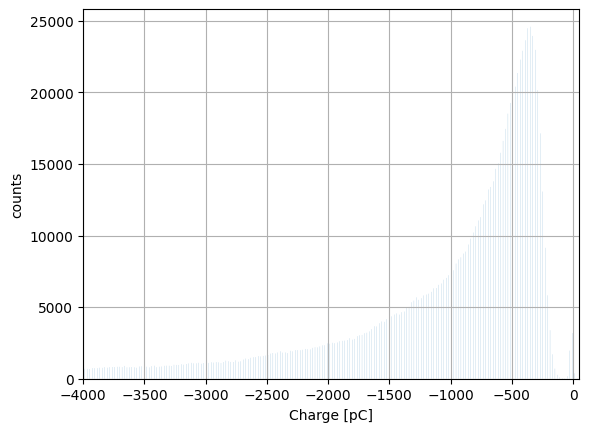

In [531]:
lim_N = [-4000, 50]
plt.bar(centers_N, bin_N, width = 1, snap = False, alpha = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [532]:
err_N = err_N[np.where((centers_N >= lim_N[0]) & (centers_N <= lim_N[1]))]
bin_N = bin_N[np.where((centers_N >= lim_N[0]) & (centers_N <= lim_N[1]))]
centers_N = centers_N[np.where((centers_N >= lim_N[0]) & (centers_N <= lim_N[1]))]

In [533]:
np.where(err_N == 0)

(array([], dtype=int64),)

In [534]:
from lmfit.models import GaussianModel, StepModel, ExponentialModel
from lmfit import Model

#DEFINIAMO IL MODELLO
Step1   = StepModel(prefix='fd1_', form = "logistic") #Esponenziale 
Step2   = StepModel(prefix='fd2_', form = "logistic") #Esponenziale 
Step3   = StepModel(prefix='fd3_', form = "logistic") #Esponenziale 
Exp1    = ExponentialModel(prefix = 'e1_')

gauss  = GaussianModel(prefix='g1_')    #Gaussiana 

sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide


params = Step1.guess(bin_N, x=centers_N)
params.update(Step2.guess(bin_N, x=centers_N))
params.update(Step3.guess(bin_N, x=centers_N))


params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss.guess(bin_N, x=centers_N))

params.update(Exp1.guess(bin_N, x=centers_N))


params["fd1_amplitude"].min = 0
params["fd2_amplitude"].min = 0
params["fd3_amplitude"].min = 0


params["fd1_amplitude"].value = 2200
params["fd1_center"].value = -1400
params["fd1_sigma"].value = 65


params["fd2_amplitude"].value = 1000
params["fd2_center"].value = -2500
params["fd2_sigma"].value = 136


params["fd3_amplitude"].value = 100
params["fd3_center"].value = -450
params["fd3_sigma"].value = 22


params["s1_amplitude"].value = 1
params["s1_amplitude"].vary = False

params["s1_center"].value = -260  
params["s1_sigma"].value = 30

params["s1_center"].max = 0
params["s1_center"].min = -1000  

params["s1_sigma"].max = 100
params["s1_sigma"].min = 0


params["g1_center"].value = -15
params["g1_sigma"].value = 5
params["g1_height"].value = 2000

params["g1_center"].min = -40
params["g1_center"].max = 5

params['e1_amplitude'].value = 26600
params['e1_decay'].value = -300

params['e1_amplitude'].min = 0

def const1(x):
    return 1


model = (Step1 + Step2 + Step3 + Exp1) * (Model(const1) - sigmoid1) + gauss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


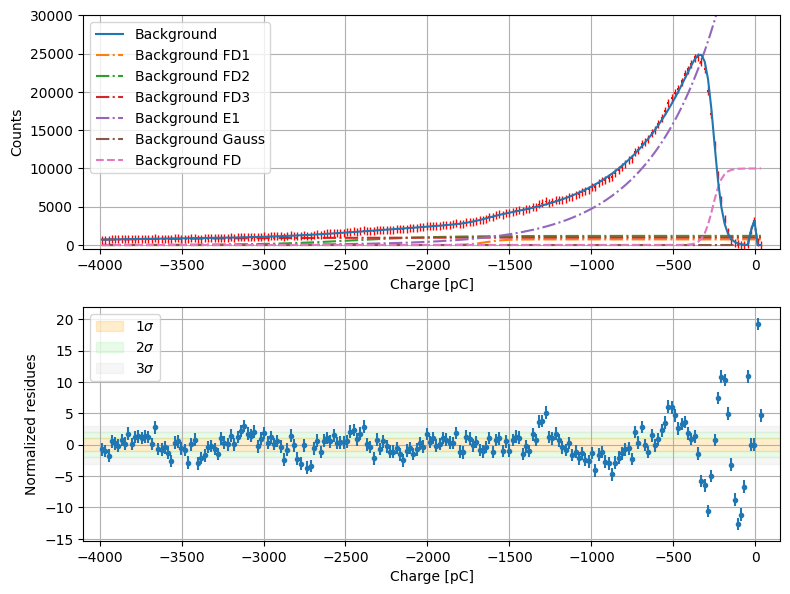

In [538]:
#FIT

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti

ax1.plot(centers_N, (comps['fd1_'] + comps['fd2_'] + comps['fd3_'] + comps['e1_']) * (1 - comps['s1_']) + comps['g1_'], label='Background', zorder = 10)
ax1.plot(centers_N, comps['fd1_'], label='Background FD1', ls = "-.")
ax1.plot(centers_N, comps['fd2_'], label='Background FD2', ls = "-.")
ax1.plot(centers_N, comps['fd3_'], label='Background FD3', ls = "-.")
ax1.plot(centers_N, comps['e1_'], label='Background E1', ls = "-.")

ax1.plot(centers_N, comps['g1_'], label='Background Gauss', ls = "-.")

ax1.plot(centers_N, comps['s1_'] * 10000, label='Background FD', ls = "--")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
ax1.set_xlim([-4100, 150])
ax2.set_xlim([-4100, 150])

ax1.set_ylim([-500, 30000])


plt.show()



In [539]:
print(result.fit_report())

[[Model]]
    (((((Model(step, prefix='fd1_', form='logistic') + Model(step, prefix='fd2_', form='logistic')) + Model(step, prefix='fd3_', form='logistic')) + Model(exponential, prefix='e1_')) * (Model(const1) - Model(step, prefix='s1_', form='logistic'))) + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 594
    # data points      = 200
    # variables        = 16
    chi-square         = 2001.07298
    reduced chi-square = 10.8753966
    Akaike info crit   = 492.624288
    Bayesian info crit = 545.397366
    R-squared          = 0.99999971
[[Variables]]
    fd1_amplitude:  736.161751 +/- 199.991604 (27.17%) (init = 2200)
    fd1_center:    -1645.15914 +/- 31.5050392 (1.92%) (init = -1400)
    fd1_sigma:      57.2916511 +/- 30.4212229 (53.10%) (init = 65)
    fd2_amplitude:  1195.44120 +/- 873.180762 (73.04%) (init = 1000)
    fd2_center:    -2464.82436 +/- 86.4058101 (3.51%) (init = -2500)
    fd2_sigma:      266.053215 +/- 